In [1]:
WORKSPACE_PATH = 'workspace/training_demo'
SCRIPTS_PATH = 'scripts'
APIMODEL_PATH = 'models'
ANNOTATION_PATH = WORKSPACE_PATH + '/annotations'
IMAGE_PATH = WORKSPACE_PATH + '/images'
MODEL_PATH = WORKSPACE_PATH + '/models'
PRE_TRAINED_MODEL_PATH = WORKSPACE_PATH + '/pre-trained-models'
CONFIG_PATH = MODEL_PATH + '/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH + '/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/'
CUSTOM_MODEL_NAME = 'my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'

In [2]:
labels = [{'name':'damage', 'id':1}]

In [3]:
labels

[{'name': 'damage', 'id': 1}]

In [4]:
with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [5]:
!python {SCRIPTS_PATH + '/preprocessing/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}

Successfully created the TFRecord file: workspace/training_demo/annotations/train.record


In [6]:
!python {SCRIPTS_PATH + '/preprocessing/generate_tfrecord.py'} -x {IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: workspace/training_demo/annotations/test.record


Clone https://github.com/tensorflow/models in the current working directory

In [7]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [8]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [9]:
config

{'model': ssd {
   num_classes: 3
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [10]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, 'r') as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [11]:
pipeline_config.model.ssd.num_classes = 1
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRE_TRAINED_MODEL_PATH + '/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type='detection'
pipeline_config.train_input_reader.label_map_path=ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH+'/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH+'/test.record']

In [12]:
pipeline_config

model {
  ssd {
    num_classes: 1
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
 

In [13]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:
    f.write(config_text)

In [14]:
print(f'python {APIMODEL_PATH}/research/object_detection/model_main_tf2.py --model_dir={MODEL_PATH}/{CUSTOM_MODEL_NAME} --pipeline_config_path={CONFIG_PATH} --num_train_steps=10000')

python models/research/object_detection/model_main_tf2.py --model_dir=workspace/training_demo/models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 --pipeline_config_path=workspace/training_demo/models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config --num_train_steps=10000


In [15]:
!python models/research/object_detection/model_main_tf2.py --model_dir=workspace/training_demo/models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 --pipeline_config_path=workspace/training_demo/models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config --num_train_steps=10000

2022-04-02 08:21:48.709617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-02 08:21:49.240297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2151 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0402 08:21:49.437513 19392 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0402 08:21:49.442511 19392 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:

INFO:tensorflow:Step 1400 per-step time 0.140s
I0402 08:25:56.211762 19392 model_lib_v2.py:705] Step 1400 per-step time 0.140s
INFO:tensorflow:{'Loss/classification_loss': 0.39023644,
 'Loss/localization_loss': 0.4172258,
 'Loss/regularization_loss': 0.15296751,
 'Loss/total_loss': 0.9604297,
 'learning_rate': 0.07998685}
I0402 08:25:56.211762 19392 model_lib_v2.py:708] {'Loss/classification_loss': 0.39023644,
 'Loss/localization_loss': 0.4172258,
 'Loss/regularization_loss': 0.15296751,
 'Loss/total_loss': 0.9604297,
 'learning_rate': 0.07998685}
INFO:tensorflow:Step 1500 per-step time 0.155s
I0402 08:26:11.722990 19392 model_lib_v2.py:705] Step 1500 per-step time 0.155s
INFO:tensorflow:{'Loss/classification_loss': 0.5640607,
 'Loss/localization_loss': 0.6236215,
 'Loss/regularization_loss': 0.1527427,
 'Loss/total_loss': 1.3404249,
 'learning_rate': 0.07997945}
I0402 08:26:11.722990 19392 model_lib_v2.py:708] {'Loss/classification_loss': 0.5640607,
 'Loss/localization_loss': 0.623621

In [16]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [17]:
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-11')).expect_partial()

In [18]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [19]:
import cv2
import numpy as np

In [20]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH + '/label_map.pbtxt')


In [21]:
category_index

{1: {'id': 1, 'name': 'damage'}}

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

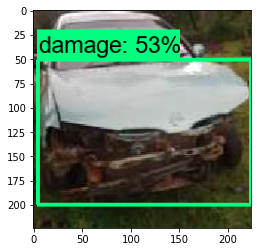

In [23]:
img_path = os.path.join(IMAGE_PATH, 'test', '546.jpeg')
img = cv2.imread(img_path)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=1,
            min_score_thresh=0.3,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()